# **LightGBM model for dynamic and static data - feature set 3**

We will now construct a LGBM model that can predict based on both the aggregated time series data as well as the static data for each patient.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import json
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


**Load the data**

In [ ]:
# Load the data
train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/02_lgbm_data/train_aggregated_v2.parquet'
test_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/02_lgbm_data/test_aggregated_v2.parquet'

train_dynamic = pd.read_parquet(train_path)
test_dynamic = pd.read_parquet(test_path)

train_dynamic.head()

subject_id  mode_GCS - Eye Opening  mode_GCS - Motor Response  \
0    10001884                     3.0                        6.0   
1    10002428                     3.0                        6.0   
2    10004235                     4.0                        6.0   
3    10010867                     2.0                        4.0   
4    10011365                     4.0                        6.0   

   mode_Richmond-RAS Scale  mean_Arterial Base Excess  \
0                     -1.0                   1.391908   
1                      0.0                   4.000000   
2                     -1.0                  -5.000000   
3                     -4.0                   1.391908   
4                      0.0                   1.391908   

   mean_Arterial Blood Pressure diastolic  mean_Arterial Blood Pressure mean  \
0                               68.416171                          81.300472   
1                               61.666667                          81.166667   
2                               68.416171                          81.300472   
3                               68.416171                          81.300472   
4                               68.416171                          81.300472   

   mean_Arterial Blood Pressure systolic  mean_Arterial CO2 Pressure  \
0                             117.652355                   40.689586   
1                             118.500000                   43.000000   
2                             117.652355                   37.500000   
3                             117.652355                   40.689586   
4                             117.652355                   40.689586   

   mean_Arterial O2 Saturation  ...  mean_Plateau Pressure  \
0                     96.63619  ...              18.102286   
1                     96.63619  ...              18.102286   
2                     97.00000  ...              18.102286   
3                     96.63619  ...              18.102286   
4                     96.63619  ...              18.102286   

   mean_Platelet Count  mean_Potassium (serum)  mean_Respiratory Rate  \
0           163.460736                4.046379              20.000000   
1           163.460736                4.000000              22.000000   
2            27.000000                4.300000              13.666667   
3           163.460736                4.046379              15.333333   
4           163.460736                4.046379              17.666667   

   mean_Sodium (serum)  mean_Temperature Fahrenheit  \
0           140.103825                    98.862106   
1           143.000000                    98.366667   
2           134.000000                    98.862106   
3           140.103825                    99.300000   
4           140.103825                    98.800000   

   mean_Tidal Volume (observed)  mean_Tidal Volume (spontaneous)   mean_WBC  \
0                    472.138379                       470.899154  11.633799   
1                    380.000000                       355.250000  11.633799   
2                    472.138379                       470.899154  15.300000   
3                    467.000000                       467.000000  11.633799   
4                    344.000000                       344.000000  11.633799   

   extubation_failure  
0                   1  
1                   0  
2                   1  
3                   0  
4                   1  

[5 rows x 36 columns]

In [ ]:
print(f"Train dynamic shape: {train_dynamic.shape}")
print(f"Test dynamic shape: {test_dynamic.shape}")

Train dynamic shape: (3760, 36)
Test dynamic shape: (941, 36)


In [ ]:
train_dynamic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760 entries, 0 to 3759
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   subject_id                              3760 non-null   int64  
 1   mode_GCS - Eye Opening                  3760 non-null   float64
 2   mode_GCS - Motor Response               3760 non-null   float64
 3   mode_Richmond-RAS Scale                 3760 non-null   float64
 4   mean_Arterial Base Excess               3760 non-null   float64
 5   mean_Arterial Blood Pressure diastolic  3760 non-null   float64
 6   mean_Arterial Blood Pressure mean       3760 non-null   float64
 7   mean_Arterial Blood Pressure systolic   3760 non-null   float64
 8   mean_Arterial CO2 Pressure              3760 non-null   float64
 9   mean_Arterial O2 Saturation             3760 non-null   float64
 10  mean_Arterial O2 pressure               3760 non-null   floa

**For feature set 3 the static data is the same as feature set 2.**

In [ ]:
# Load the static data
train_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/static_data/train_static.parquet'
test_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/static_data/test_static.parquet'

train_static = pd.read_parquet(train_static_path)
test_static = pd.read_parquet(test_static_path)

# Print the shapes of the loaded data
print(f"Train static shape: {train_static.shape}")
print(f"Test static shape: {test_static.shape}")

Train static shape: (3760, 15)
Test static shape: (941, 15)


In [ ]:
train_static.head()

subject_id    weight    height       BMI  age_group_55-64  age_group_65-74  \
0    10001884  0.307331  0.250000  0.337538              0.0              1.0   
1    10002428  0.100564  0.104167  0.175384              0.0              0.0   
2    10004235  0.890038  0.791667  0.595601              0.0              0.0   
3    10010867  0.824248  0.520833  0.676008              0.0              0.0   
4    10011365  0.131579  0.250000  0.168071              0.0              1.0   

   age_group_≤44  age_group_≥75  gender_M  ethnicity_ASIAN  ethnicity_BLACK  \
0            0.0            0.0       0.0              0.0              1.0   
1            0.0            1.0       0.0              1.0              0.0   
2            0.0            0.0       1.0              0.0              1.0   
3            1.0            0.0       0.0              0.0              0.0   
4            0.0            0.0       0.0              1.0              0.0   

   ethnicity_HISPANIC  ethnicity_OTHER  ethnicity_WHITE  charlson_score  
0                 0.0              0.0              0.0             2.0  
1                 0.0              0.0              0.0             4.0  
2                 0.0              0.0              0.0             0.0  
3                 0.0              0.0              1.0             0.0  
4                 0.0              0.0              0.0            13.0

**Combine dynamic and static data**

In [ ]:
# Merge datasets
train_data = pd.merge(train_dynamic, train_static, on='subject_id')
test_data = pd.merge(test_dynamic, test_static, on='subject_id')

# Make extubation_failure the last column
extubation_failure = train_data.pop('extubation_failure')
train_data['extubation_failure'] = extubation_failure

extubation_failure = test_data.pop('extubation_failure')
test_data['extubation_failure'] = extubation_failure

train_data.head()

subject_id  mode_GCS - Eye Opening  mode_GCS - Motor Response  \
0    10001884                     3.0                        6.0   
1    10002428                     3.0                        6.0   
2    10004235                     4.0                        6.0   
3    10010867                     2.0                        4.0   
4    10011365                     4.0                        6.0   

   mode_Richmond-RAS Scale  mean_Arterial Base Excess  \
0                     -1.0                   1.391908   
1                      0.0                   4.000000   
2                     -1.0                  -5.000000   
3                     -4.0                   1.391908   
4                      0.0                   1.391908   

   mean_Arterial Blood Pressure diastolic  mean_Arterial Blood Pressure mean  \
0                               68.416171                          81.300472   
1                               61.666667                          81.166667   
2                               68.416171                          81.300472   
3                               68.416171                          81.300472   
4                               68.416171                          81.300472   

   mean_Arterial Blood Pressure systolic  mean_Arterial CO2 Pressure  \
0                             117.652355                   40.689586   
1                             118.500000                   43.000000   
2                             117.652355                   37.500000   
3                             117.652355                   40.689586   
4                             117.652355                   40.689586   

   mean_Arterial O2 Saturation  ...  age_group_≤44  age_group_≥75  gender_M  \
0                     96.63619  ...            0.0            0.0       0.0   
1                     96.63619  ...            0.0            1.0       0.0   
2                     97.00000  ...            0.0            0.0       1.0   
3                     96.63619  ...            1.0            0.0       0.0   
4                     96.63619  ...            0.0            0.0       0.0   

   ethnicity_ASIAN  ethnicity_BLACK  ethnicity_HISPANIC  ethnicity_OTHER  \
0              0.0              1.0                 0.0              0.0   
1              1.0              0.0                 0.0              0.0   
2              0.0              1.0                 0.0              0.0   
3              0.0              0.0                 0.0              0.0   
4              1.0              0.0                 0.0              0.0   

   ethnicity_WHITE  charlson_score  extubation_failure  
0              0.0             2.0                   1  
1              0.0             4.0                   0  
2              0.0             0.0                   1  
3              1.0             0.0                   0  
4              0.0            13.0                   1  

[5 rows x 50 columns]

**Split into X and y**

In [ ]:
# Separate X_train and y_train
X_train = train_data.drop(columns=['subject_id', 'extubation_failure'])
y_train = train_data['extubation_failure']

# Separate X_test and y_test
X_test = test_data.drop(columns=['subject_id', 'extubation_failure'])
y_test = test_data['extubation_failure']

In [ ]:
def clean_column_names(df):
  # Replace special characters in column names with underscores
  df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
  return df

In [ ]:
# Clean columns to remove special characters
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

# Remove any _ at the end of column names
X_train.columns = X_train.columns.str.rstrip('_')
X_test.columns = X_test.columns.str.rstrip('_')

print(X_train.columns)
print(X_test.columns)

Index(['mode_GCS_Eye_Opening', 'mode_GCS_Motor_Response',
       'mode_Richmond_RAS_Scale', 'mean_Arterial_Base_Excess',
       'mean_Arterial_Blood_Pressure_diastolic',
       'mean_Arterial_Blood_Pressure_mean',
       'mean_Arterial_Blood_Pressure_systolic', 'mean_Arterial_CO2_Pressure',
       'mean_Arterial_O2_Saturation', 'mean_Arterial_O2_pressure',
       'mean_Cardiac_Output_CCO', 'mean_Creatinine_serum', 'mean_EtCO2',
       'mean_Glucose_serum', 'mean_Heart_Rate', 'mean_Hematocrit_serum',
       'mean_Hemoglobin', 'mean_Inspired_O2_Fraction', 'mean_Ionized_Calcium',
       'mean_Lactic_Acid', 'mean_Mean_Airway_Pressure', 'mean_Minute_Volume',
       'mean_O2_saturation_pulseoxymetry', 'mean_PH_Arterial',
       'mean_Peak_Insp_Pressure', 'mean_Plateau_Pressure',
       'mean_Platelet_Count', 'mean_Potassium_serum', 'mean_Respiratory_Rate',
       'mean_Sodium_serum', 'mean_Temperature_Fahrenheit',
       'mean_Tidal_Volume_observed', 'mean_Tidal_Volume_spontaneous',
       '

**Functions to over and undersample data**

In [ ]:
def undersample_data(X, y):
    rus = RandomUnderSampler()
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

def oversample_data(X, y):
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# **Experiment 1**

We can now run Bayesian Optimisation for hyperparameter tuning.

We will be using the same param grid as the model with the dynamic data for consistency.

In [ ]:
# Give an extensive grid of hyperparameter ranges
param_grid = {
    'num_leaves': [20, 30, 40, 50, 60, 70, 80, 90, 100], # Number of leaves in each tree
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], # Maximum depth of the tree
    'min_data_in_leaf': [20, 30, 40, 50, 60, 70, 80, 90, 100], # Minimum number of data in a leaf
    'learning_rate': [0.0001, 0.001, 0.01, 0.1], # Learning rate
    'sampling_method': ['normal', 'undersample', 'oversample'], # Sampling method
    'lambda_l2': [0.0001, 0.001, 0.01, 0.1] # L2 regularization term
}

In [ ]:
from sklearn.metrics import roc_auc_score
from lightgbm import early_stopping

In [ ]:
def objective_wrapper(train_data, param_grid):
    def objective(trial):
        param = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_categorical('num_leaves', param_grid['num_leaves']),
            'max_depth': trial.suggest_categorical('max_depth', param_grid['max_depth']),
            'learning_rate': trial.suggest_categorical('learning_rate', param_grid['learning_rate']),
            'min_data_in_leaf': trial.suggest_categorical('min_data_in_leaf', param_grid['min_data_in_leaf']),
            'lambda_l2': trial.suggest_categorical('lambda_l2', param_grid['lambda_l2'])
        }

        # Choose the sampling method
        sampling_method = trial.suggest_categorical('sampling_method', param_grid['sampling_method'])

        # Resample the training data if necessary
        if sampling_method == 'undersample':
            X_resampled, y_resampled = undersample_data(train_data[0], train_data[1])
        elif sampling_method == 'oversample':
            X_resampled, y_resampled = oversample_data(train_data[0], train_data[1])
        else:
            X_resampled, y_resampled = train_data[0], train_data[1]

        # Create the LightGBM dataset
        train_data_lgb = lgb.Dataset(X_resampled, label=y_resampled)

        # Perform cross-validation with early stopping
        cv_results = lgb.cv(
            param,
            train_data_lgb,
            nfold=5,
            stratified=True,
            shuffle=True,
            metrics='auc',
            seed=42,
            callbacks=[early_stopping(stopping_rounds=10)]
        )

        # Return the best score
        return np.max(cv_results['valid auc-mean'])

    return objective

In [ ]:
# Run Bayesian Optimisation
study = optuna.create_study(direction='maximize')
objective = objective_wrapper((X_train, y_train), param_grid)
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best hyperparameters:", best_params)
best_score = study.best_value
print("Best score:", best_score)

# Save the best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/03_lgbm_model/static_and_dynamic_data/best_models/best_params_v2.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
best_params

{'num_leaves': 60,
 'max_depth': 9,
 'learning_rate': 0.1,
 'min_data_in_leaf': 30,
 'lambda_l2': 0.0001,
 'sampling_method': 'oversample'}

In [ ]:
best_score

0.8376653269287324

**Train final model**


In [ ]:
final_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    num_leaves=best_params['num_leaves'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_data_in_leaf=best_params['min_data_in_leaf'],
    lambda_l2=best_params['lambda_l2']
  )

final_model

LGBMClassifier(lambda_l2=0.0001, max_depth=9, metric='auc', min_data_in_leaf=30,
               num_leaves=60, objective='binary')

In [ ]:
# Prepare the data with the best sampling method
if best_params['sampling_method'] == 'undersample':
    X_resampled, y_resampled = undersample_data(X_train, y_train)
elif best_params['sampling_method'] == 'oversample':
    X_resampled, y_resampled = oversample_data(X_train, y_train)
else:
    X_resampled, y_resampled = X_train, y_train

In [ ]:
# Train the model
final_model.fit(X_resampled, y_resampled)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Info] Number of positive: 2525, number of negative: 2525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10469
[LightGBM] [Info] Number of data points in the train set: 5050, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further spl

LGBMClassifier(lambda_l2=0.0001, max_depth=9, metric='auc', min_data_in_leaf=30,
               num_leaves=60, objective='binary')

In [ ]:
# Save the trained model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/03_lgbm_model/static_and_dynamic_data/best_models/final_model_v2.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

**Evaluate model**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_lgbm_model(model, X_test, y_test):
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return y_pred_proba

In [ ]:
evaluate_lgbm_model(final_model, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
Accuracy: 0.6706
Precision: 0.4975
Recall (Sensitivity): 0.3236
F1 Score: 0.3922
ROC AUC: 0.5819
Specificity: 0.8402


(0.6705632306057385,
 0.4975124378109453,
 0.32362459546925565,
 0.3921568627450981,
 0.5819072344434886,
 0.8401898734177216)

In [ ]:
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/03_lgbm_model/static_and_dynamic_data/best_models/final_model_v2.pkl'
with open(model_path, 'rb') as f:
    final_model = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
predictions = evaluate_lgbm_model(final_model, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
Accuracy: 0.6706
Precision: 0.4975
Recall (Sensitivity): 0.3236
F1 Score: 0.3922
ROC AUC: 0.6517
Specificity: 0.8402


In [ ]:
np.save('/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/03_lgbm_model/static_and_dynamic_data/best_models/predictions_v2.npy', predictions)

**Confusion matrix**

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=None, normalize=False, title='Confusion Matrix'):
    """
    Plot the confusion matrix using Seaborn heatmap.

    Parameters:
    - y_true: array-like of shape (n_samples,) Ground truth (correct) target values.
    - y_pred: array-like of shape (n_samples,) Estimated targets as returned by a classifier.
    - labels: array-like of shape (n_classes,), default=None List of labels to index the matrix.
    - normalize: bool, default=False If True, normalize the confusion matrix.
    - title: str, default='Confusion Matrix' Title for the heatmap.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Normalize the confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a DataFrame for the confusion matrix
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt=".2f" if normalize else "d", cmap="Blues")
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001


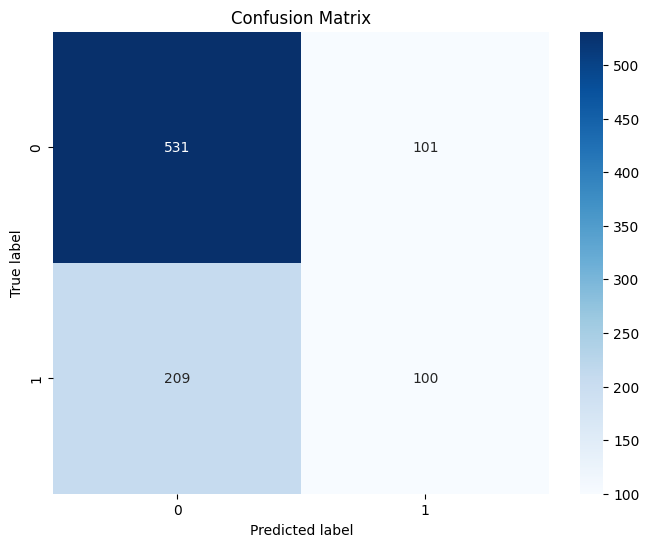

In [ ]:
y_pred = (final_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
labels = [0, 1]
plot_confusion_matrix(y_test, y_pred, labels=labels, normalize=False, title='Confusion Matrix')

### **Model Interpretability**

In [ ]:
def plot_feature_importance(model, max_num_features=20):
    # Get the booster from the trained LGBMClassifier
    booster = model.booster_

    # Get feature importances
    importance = booster.feature_importance(importance_type='gain')
    feature_names = booster.feature_name()
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(max_num_features))
    plt.title('Feature Importance')
    plt.show()

    return feature_importances

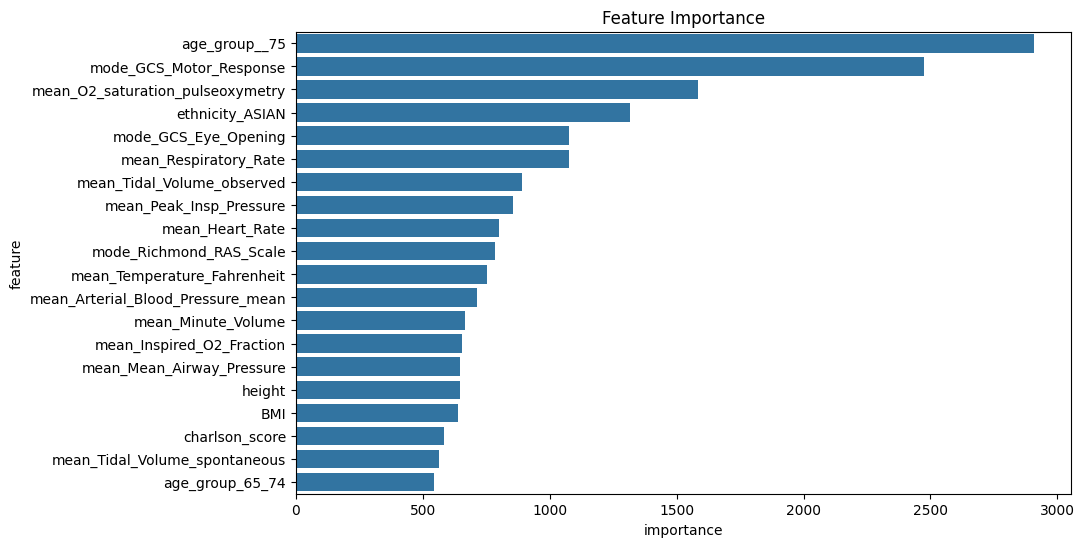

In [ ]:
feature_importances = plot_feature_importance(final_model)

In [ ]:
feature_importances

feature   importance
40                           age_group__75  2908.043535
1                  mode_GCS_Motor_Response  2476.518902
22        mean_O2_saturation_pulseoxymetry  1584.329060
42                         ethnicity_ASIAN  1316.925060
0                     mode_GCS_Eye_Opening  1075.886589
28                   mean_Respiratory_Rate  1074.538485
31              mean_Tidal_Volume_observed   891.118520
24                 mean_Peak_Insp_Pressure   854.513041
14                         mean_Heart_Rate   799.675026
2                  mode_Richmond_RAS_Scale   785.787899
30             mean_Temperature_Fahrenheit   752.071082
5        mean_Arterial_Blood_Pressure_mean   715.435913
21                      mean_Minute_Volume   665.707688
17               mean_Inspired_O2_Fraction   655.147584
20               mean_Mean_Airway_Pressure   646.396353
35                                  height   645.704610
36                                     BMI   638.640320
47                          charlson_score   585.011796
32           mean_Tidal_Volume_spontaneous   564.577136
38                         age_group_65_74   544.011570
34                                  weight   542.007089
41                                gender_M   475.704598
37                         age_group_55_64   406.890681
4   mean_Arterial_Blood_Pressure_diastolic   387.077767
6    mean_Arterial_Blood_Pressure_systolic   343.202425
7               mean_Arterial_CO2_Pressure   307.384243
33                                mean_WBC   245.598639
9                mean_Arterial_O2_pressure   241.326621
39                           age_group__44   229.062759
23                        mean_PH_Arterial   213.049236
15                   mean_Hematocrit_serum   210.993411
25                   mean_Plateau_Pressure   200.155386
16                         mean_Hemoglobin   173.803610
11                   mean_Creatinine_serum   163.834486
27                    mean_Potassium_serum   149.975576
13                      mean_Glucose_serum   137.994039
3                mean_Arterial_Base_Excess   132.886405
29                       mean_Sodium_serum   131.008082
19                        mean_Lactic_Acid   124.512690
18                    mean_Ionized_Calcium   113.905133
12                              mean_EtCO2   113.614106
8              mean_Arterial_O2_Saturation   113.258422
26                     mean_Platelet_Count   106.006762
10                 mean_Cardiac_Output_CCO    55.743380
44                      ethnicity_HISPANIC     5.034110
43                         ethnicity_BLACK     0.000000
45                         ethnicity_OTHER     0.000000
46                         ethnicity_WHITE     0.000000

The score 0 indicates that several features may be redundant or irrelevant.

It seems that the majority of the static features are irrelevant.

LightGBM has built-in mechanisms for feature selection. During the training process, it can decide to ignore certain features if they do not improve the model's performance.

**Feature ablation**

In [ ]:
def feature_ablation(model, X_train, y_train, X_test, y_test, params, num_boost_round=100):
    # Function to train and evaluate the model
    def train_and_evaluate(X_train, y_train, X_test, y_test):
        train_data = lgb.Dataset(X_train, label=y_train)
        model = lgb.train(params, train_data, num_boost_round=num_boost_round)
        y_pred = model.predict(X_test)
        y_pred_binary = (y_pred >= 0.5).astype(int)

        accuracy = accuracy_score(y_test, y_pred_binary)
        roc_auc = roc_auc_score(y_test, y_pred)
        return accuracy, roc_auc

    # Baseline model with all features
    baseline_accuracy, baseline_roc_auc = train_and_evaluate(X_train, y_train, X_test, y_test)

    # Store results
    results = []

    # Perform feature ablation
    for feature in X_train.columns:
        X_train_ablate = X_train.drop(columns=[feature])
        X_test_ablate = X_test.drop(columns=[feature])

        accuracy, roc_auc = train_and_evaluate(X_train_ablate, y_train, X_test_ablate, y_test)

        results.append({
            'feature': feature,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'accuracy_drop': baseline_accuracy - accuracy,
            'roc_auc_drop': baseline_roc_auc - roc_auc
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot the results
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    sns.barplot(x='accuracy_drop', y='feature', data=results_df.sort_values(by='accuracy_drop', ascending=False), ax=axes[0])
    axes[0].set_title('Drop in Accuracy After Feature Ablation')
    axes[0].set_xlabel('Drop in Accuracy')

    sns.barplot(x='roc_auc_drop', y='feature', data=results_df.sort_values(by='roc_auc_drop', ascending=False), ax=axes[1])
    axes[1].set_title('Drop in ROC AUC After Feature Ablation')
    axes[1].set_xlabel('Drop in ROC AUC')

    plt.tight_layout()
    plt.show()

    return results_df

[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10469
[LightGBM] [Info] Number of data points in the train set: 5050, number of used features: 48
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

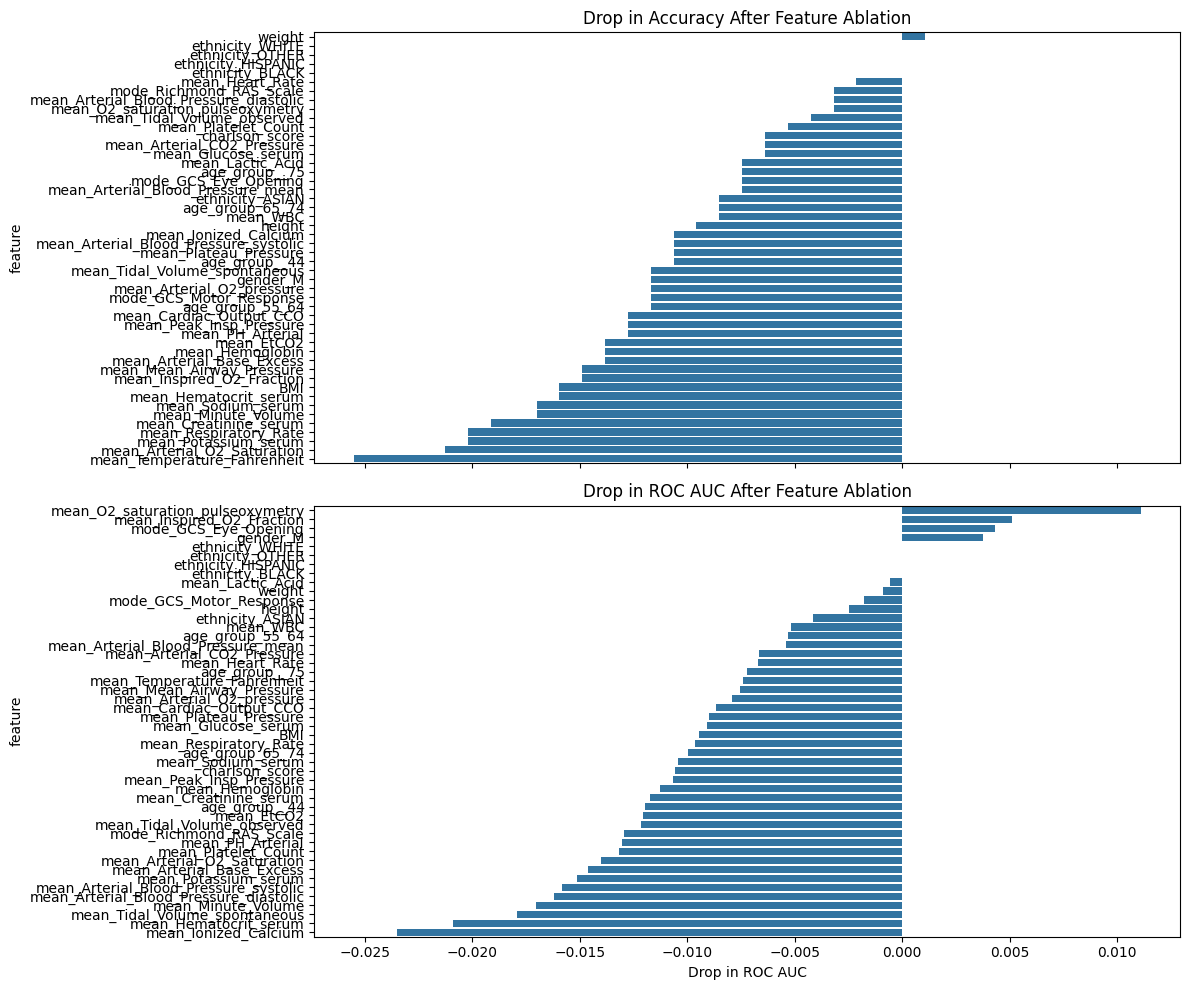

In [ ]:
results_df = feature_ablation(final_model, X_resampled, y_resampled, X_test, y_test, best_params)

In [ ]:
results_df

feature  accuracy   roc_auc  accuracy_drop  \
0                     mode_GCS_Eye_Opening  0.678002  0.642784      -0.007439   
1                  mode_GCS_Motor_Response  0.682253  0.648903      -0.011690   
2                  mode_Richmond_RAS_Scale  0.673751  0.660035      -0.003188   
3                mean_Arterial_Base_Excess  0.684378  0.661746      -0.013815   
4   mean_Arterial_Blood_Pressure_diastolic  0.673751  0.663302      -0.003188   
5        mean_Arterial_Blood_Pressure_mean  0.678002  0.652518      -0.007439   
6    mean_Arterial_Blood_Pressure_systolic  0.681190  0.662923      -0.010627   
7               mean_Arterial_CO2_Pressure  0.676939  0.653798      -0.006376   
8              mean_Arterial_O2_Saturation  0.691817  0.661131      -0.021254   
9                mean_Arterial_O2_pressure  0.682253  0.655038      -0.011690   
10                 mean_Cardiac_Output_CCO  0.683316  0.655775      -0.012752   
11                   mean_Creatinine_serum  0.689692  0.658858      -0.019129   
12                              mean_EtCO2  0.684378  0.659175      -0.013815   
13                      mean_Glucose_serum  0.676939  0.656195      -0.006376   
14                         mean_Heart_Rate  0.672689  0.653845      -0.002125   
15                   mean_Hematocrit_serum  0.686504  0.668029      -0.015940   
16                         mean_Hemoglobin  0.684378  0.658366      -0.013815   
17               mean_Inspired_O2_Fraction  0.685441  0.641995      -0.014878   
18                    mean_Ionized_Calcium  0.681190  0.670604      -0.010627   
19                        mean_Lactic_Acid  0.678002  0.647679      -0.007439   
20               mean_Mean_Airway_Pressure  0.685441  0.654638      -0.014878   
21                      mean_Minute_Volume  0.687566  0.664132      -0.017003   
22        mean_O2_saturation_pulseoxymetry  0.673751  0.636025      -0.003188   
23                        mean_PH_Arterial  0.683316  0.660169      -0.012752   
24                 mean_Peak_Insp_Pressure  0.683316  0.657777      -0.012752   
25                   mean_Plateau_Pressure  0.681190  0.656118      -0.010627   
26                     mean_Platelet_Count  0.675877  0.660266      -0.005313   
27                    mean_Potassium_serum  0.690755  0.662232      -0.020191   
28                   mean_Respiratory_Rate  0.690755  0.656774      -0.020191   
29                       mean_Sodium_serum  0.687566  0.657552      -0.017003   
30             mean_Temperature_Fahrenheit  0.696068  0.654531      -0.025505   
31              mean_Tidal_Volume_observed  0.674814  0.659262      -0.004251   
32           mean_Tidal_Volume_spontaneous  0.682253  0.665023      -0.011690   
33                                mean_WBC  0.679065  0.652308      -0.008502   
34                                  weight  0.669501  0.648028       0.001063   
35                                  height  0.680128  0.649574      -0.009564   
36                                     BMI  0.686504  0.656574      -0.015940   
37                         age_group_55_64  0.682253  0.652416      -0.011690   
38                         age_group_65_74  0.679065  0.657065      -0.008502   
39                           age_group__44  0.681190  0.659093      -0.010627   
40                           age_group__75  0.678002  0.654316      -0.007439   
41                                gender_M  0.682253  0.643352      -0.011690   
42                         ethnicity_ASIAN  0.679065  0.651264      -0.008502   
43                         ethnicity_BLACK  0.670563  0.647121       0.000000   
44                      ethnicity_HISPANIC  0.670563  0.647121       0.000000   
45                         ethnicity_OTHER  0.670563  0.647121       0.000000   
46                         ethnicity_WHITE  0.670563  0.647121       0.000000   
47                          charlson_score  0.676939  0.657665      -0.006376   

    roc_auc_drop  
0       0.004337  
1      -0.001782  
2      -

As per the previous study there are clearly a lot of irrelevent or redundant features.

Let's only plot where the value is not 0 to see the most important features.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_non_zero_drops(df):
    # Filter the DataFrame to include only rows where accuracy_drop or roc_auc_drop is not zero
    non_zero_drops = df[(df['accuracy_drop'] != 0) | (df['roc_auc_drop'] != 0)]

    # Plot the accuracy drop
    plt.figure(figsize=(14, 7))
    sns.barplot(x='accuracy_drop', y='feature', data=non_zero_drops.sort_values(by='accuracy_drop', ascending=False))
    plt.title('Accuracy Drop After Feature Ablation')
    plt.xlabel('Accuracy Drop')
    plt.ylabel('Feature')
    plt.show()

    # Plot the ROC AUC drop
    plt.figure(figsize=(14, 7))
    sns.barplot(x='roc_auc_drop', y='feature', data=non_zero_drops.sort_values(by='roc_auc_drop', ascending=False))
    plt.title('ROC AUC Drop After Feature Ablation')
    plt.xlabel('ROC AUC Drop')
    plt.ylabel('Feature')
    plt.show()


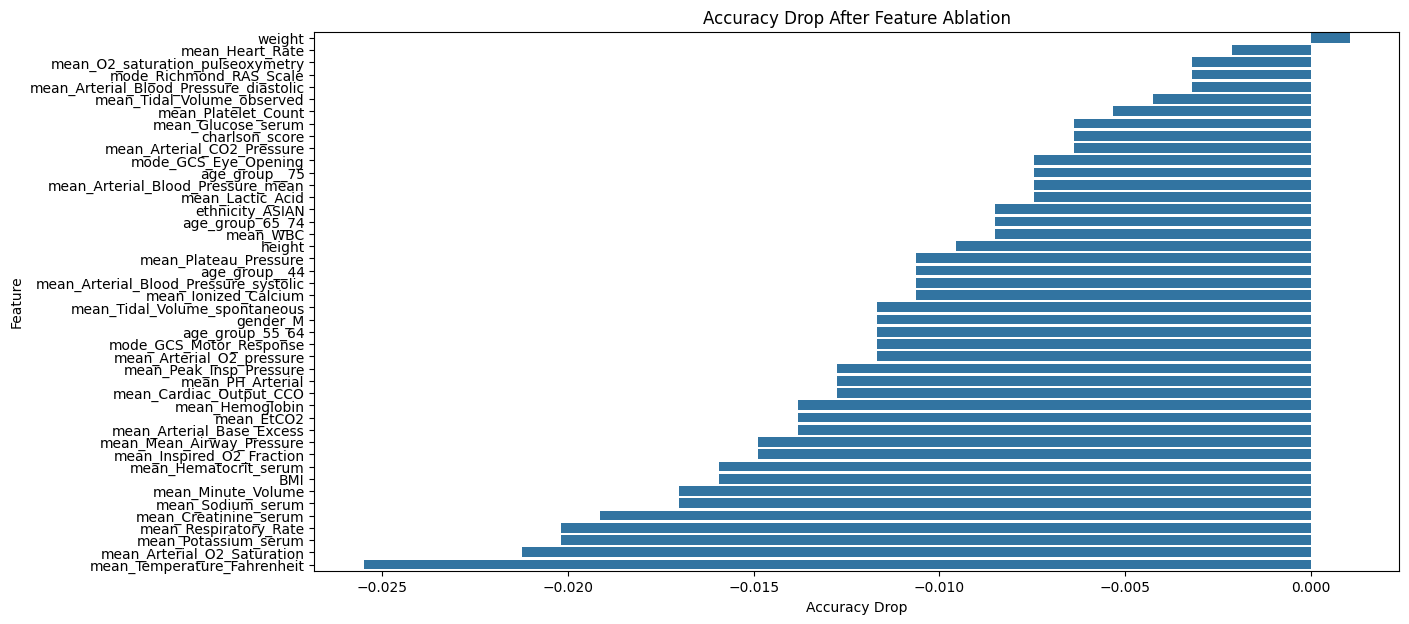

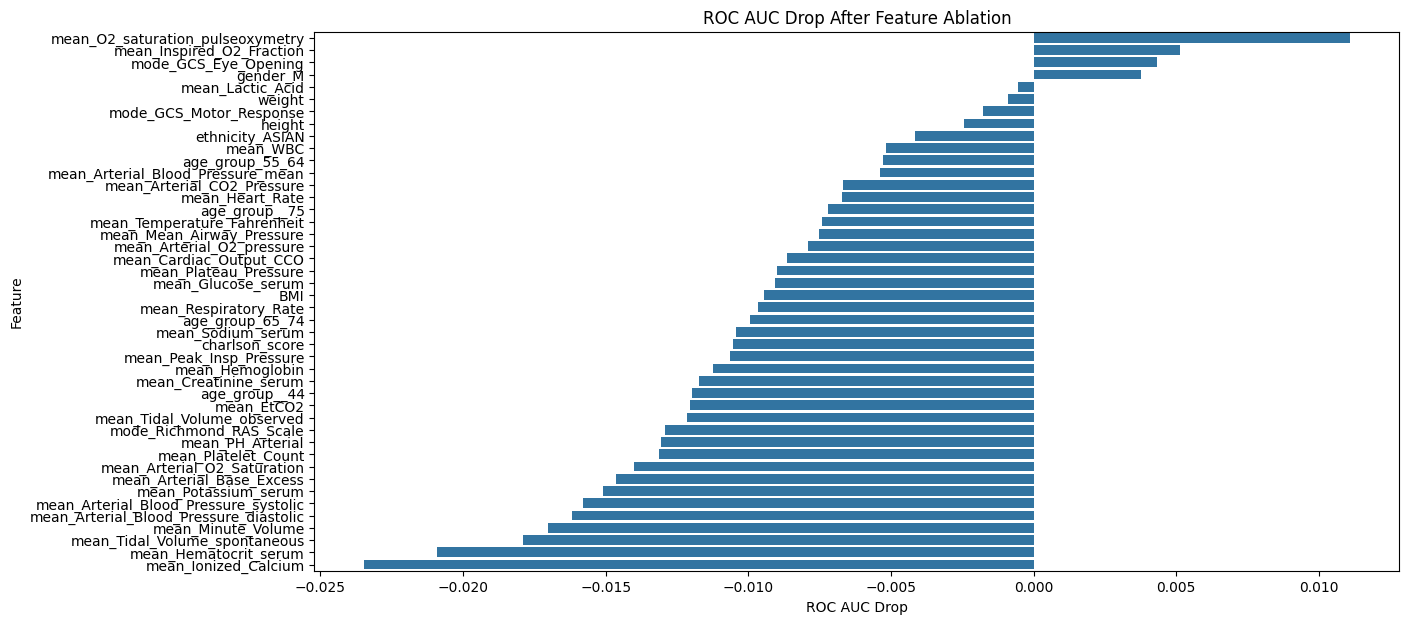

In [ ]:
plot_non_zero_drops(results_df)

This seems to match the LGBM feature importance chart.

**SHAP**

In [ ]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 17.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


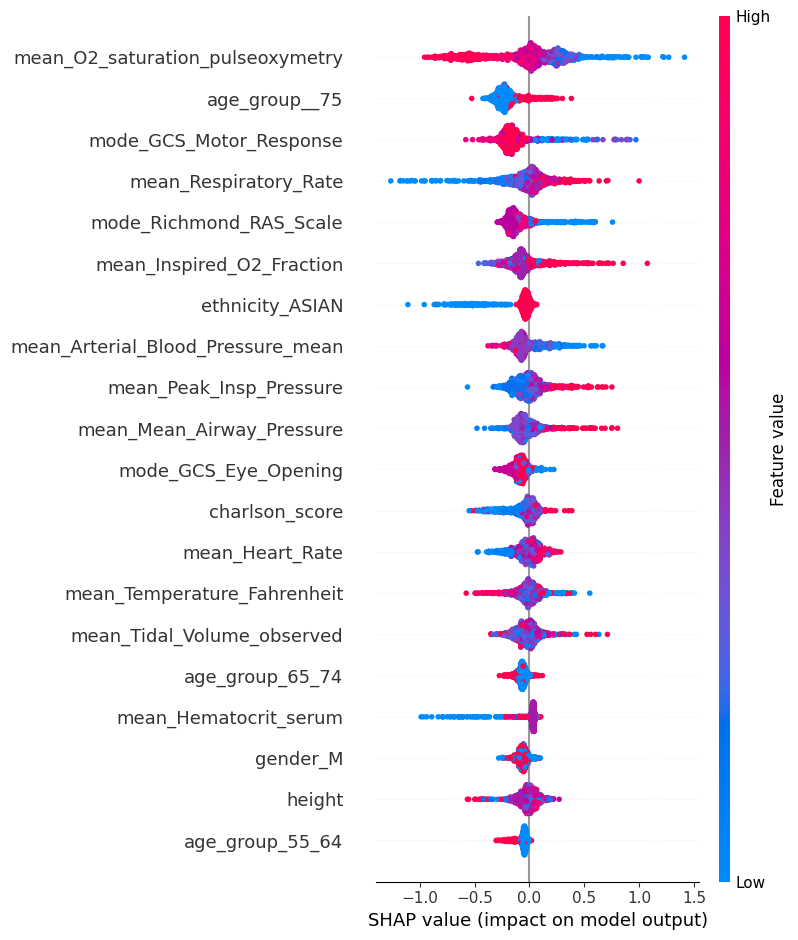

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.initjs()
shap.summary_plot(shap_values, X_test)

Also aligns with the previous feature importances.

**Results analysis**

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001


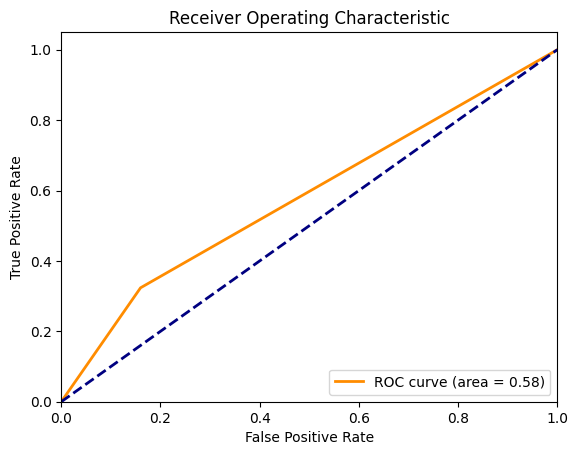

In [ ]:
y_pred_proba = final_model.predict(X_test)
plot_roc_curve(y_test, y_pred_proba)

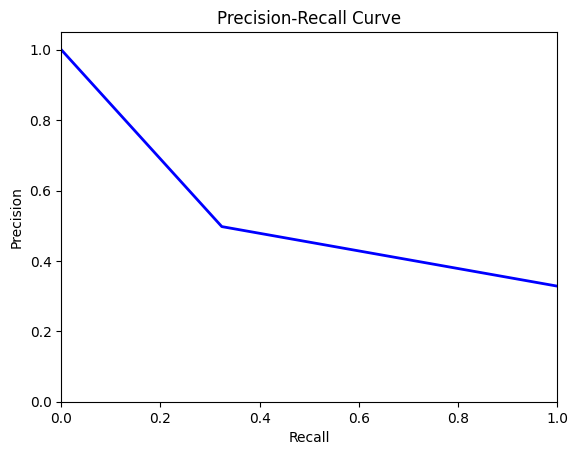

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_pred_proba)

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Function to plot a single tree with high-quality settings
def plot_single_tree_high_quality(model, tree_index, figsize=(20, 10), dpi=300):
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    lgb.plot_tree(model, tree_index=tree_index, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'], ax=ax)
    plt.show()

In [ ]:
plot_single_tree_high_quality(final_model, 0)

Output hidden; open in https://colab.research.google.com to view.

**LIME**

**Best threshold analysis**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def find_best_threshold_and_evaluate(model, X_test, y_test):
    """
    Find the best threshold for binary classification based on ROC AUC and calculate evaluation metrics.

    Parameters:
    model (LGBMClassifier): The trained LightGBM model.
    X_test (np.array or pd.DataFrame): Test features.
    y_test (np.array or pd.Series): True labels for the test data.

    Returns:
    dict: A dictionary containing the best threshold, ROC AUC, and other evaluation metrics.
    """
    # Get model output (predicted probabilities)
    all_probs = model.predict_proba(X_test)[:, 1]

    # Convert true labels to numpy array
    all_labels = np.array(y_test)

    best_threshold = 0.5
    best_metric_value = 0.0

    thresholds = np.arange(0.0, 1.0, 0.01)  # You can change the step size if needed

    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        metric_value = roc_auc_score(all_labels, preds)

        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold

    # Apply the best threshold to get the final predictions
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    metrics = {
        'best_threshold': best_threshold,
        'best_metric_value': best_metric_value,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

    print(f"Best Threshold: {best_threshold}")
    print(f"Best Metric Value: {best_metric_value}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return metrics

In [ ]:
# Find the best threshold
find_best_threshold_and_evaluate(final_model, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
Best Threshold: 0.35000000000000003
Best Metric Value: 0.6113150833640572
Accuracy: 0.6323
Precision: 0.4509
Recall: 0.5502
F1 Score: 0.4956
ROC AUC: 0.6517
Specificity: 0.6725


{'best_threshold': 0.35000000000000003,
 'best_metric_value': 0.6113150833640572,
 'accuracy': 0.6323060573857598,
 'precision': 0.4509283819628647,
 'recall': 0.5501618122977346,
 'f1_score': 0.49562682215743437,
 'roc_auc': 0.6517246323378805,
 'specificity': 0.6724683544303798}

The best threshold is the standard threshold of 0.5.